In [1]:
import os.path

import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from omegaconf import OmegaConf
from train._main import train_model
from data._main import get_dataset
from data._utils import load_Flavell2023, load_Uzel2022
from train._utils import model_predict, make_predictions
from visualization._utils import plot_targets_predictions, plot_correlation_scatterplot
from models._utils import NetworkLSTM, LinearNN, NeuralCFC
from utils import DEVICE

In [3]:
# load your trained model checkpoint of choice
PATH = "../../logs/hydra/199_epochs_19303_worms.pt"
checkpoint = torch.load(PATH, map_location=torch.device(DEVICE))
for key in checkpoint.keys():
    print(key)

epoch
loss
dataset_name
model_name
optimizer_name
learning_rate
smooth_data
timestamp
covered_neurons
input_size
hidden_size
num_layers
num_worm_cohorts
num_unique_worms
model_state_dict
optimizer_state_dict


In [4]:
# get checkpoint variables
model_name = checkpoint["model_name"]
dataset_name = checkpoint["dataset_name"]
input_size = checkpoint["input_size"]
hidden_size = checkpoint["hidden_size"]
model_state_dict = checkpoint["model_state_dict"]
optimizer_state_dict = checkpoint["optimizer_state_dict"]
num_layers = checkpoint["num_layers"]
smooth_data = checkpoint["smooth_data"]
epoch = checkpoint["epoch"]

print("{} model was trained on dataset {} for {} epochs.".format(model_name, dataset_name, epoch))

NetworkLSTM model was trained on dataset Flavell2023_Kaplan2020_Kato2015_Nichols2017_Skora2018 for 199 epochs.


In [158]:
print(checkpoint.keys())

dict_keys(['epoch', 'loss', 'dataset_name', 'model_name', 'optimizer_name', 'learning_rate', 'smooth_data', 'timestamp', 'covered_neurons', 'input_size', 'hidden_size', 'num_layers', 'num_worm_cohorts', 'num_unique_worms', 'model_state_dict', 'optimizer_state_dict'])


In [160]:
print(len(checkpoint["covered_neurons"]))

197


In [5]:
# load model checkpoint
model = eval(model_name)(input_size, hidden_size, num_layers)
model.load_state_dict(model_state_dict)
model.eval()
print(model)

# load optimizer checkpoint
optimizer = torch.optim.SGD(model.parameters(), lr=0.0) # turn off learning
optimizer.load_state_dict(optimizer_state_dict)
print(optimizer)

NetworkLSTM(
  (identity): Identity()
  (lstm): LSTM(302, 1024, batch_first=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=1024, out_features=302, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [6]:
# ideally, evaluate the model on a test dataset that it was not trained on
# dataset = load_Flavell2023() # dataset of multiple worms
dataset = load_Uzel2022() # dataset of multiple worms
for key in dataset["worm0"].keys():
    print(key)
named_neurons_mask = dataset["worm0"]["named_neurons_mask"]
if smooth_data:
    calcium_data = dataset["worm0"]["smooth_calcium_data"]
else:
    calcium_data = dataset["worm0"]["calcium_data"]
time_in_seconds = dataset["worm0"]["time_in_seconds"]
max_time = dataset["worm0"]["max_time"]

dataset
worm
calcium_data
smooth_calcium_data
residual_calcium
smooth_residual_calcium
neuron_to_idx
idx_to_neuron
max_time
time_in_seconds
dt
num_neurons
num_named_neurons
num_unknown_neurons
named_neurons_mask
unknown_neurons_mask
neurons_mask
named_neuron_to_idx
idx_to_named_neuron
unknown_neuron_to_idx
idx_to_unknown_neuron
slot_to_named_neuron
named_neuron_to_slot
slot_to_unknown_neuron
unknown_neuron_to_slot
slot_to_neuron
neuron_to_slot


In [10]:
# pick one of the labeled neurons to inspect
named_neuron_inds = torch.where(named_neurons_mask)[0].numpy()
print("named neuron indices:\n", named_neuron_inds, end="\n\n")

nidx = np.random.choice(named_neuron_inds) # pick a neuron to plot
nidx = 190
print("picked neuron index:", nidx)

named neuron indices:
 [ 12  13  22  25  26  29  49  50  53  54  55  56  59  60  61  62  88  94
  96  97  98 103 110 112 157 162 177 178 189 190 193 200 204 206 213 214
 216 227 228 229 232 233 234 235 244 245 247 256 257 258 259 260 262 263
 272 274 275 293]

picked neuron index: 190


In [11]:
# make predictions of the future timesteps
tau_out = 1
targets, predictions = model_predict(model, calcium_data[:max_time//2, :] * named_neurons_mask, tau=tau_out)
print(targets.shape, predictions.shape)

torch.Size([1656, 302]) torch.Size([1656, 302])


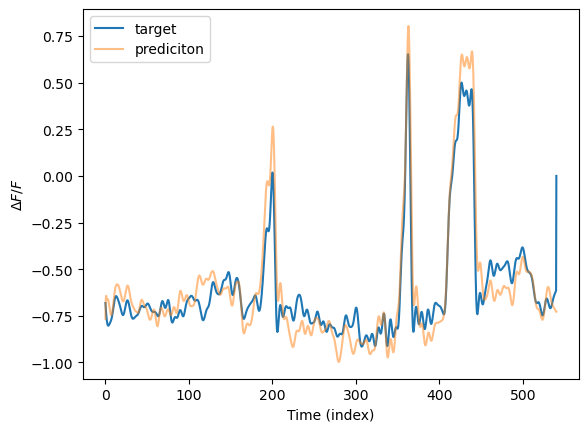

In [12]:
# plot what the predictions looks like
plt.plot(time_in_seconds[tau_out:tau_out + max_time//2], targets[:, nidx], label="target")
plt.plot(time_in_seconds[tau_out:tau_out + max_time//2], predictions[:, nidx], label="prediciton", alpha=0.5)
plt.legend()
plt.xlabel("Time (index)")
plt.ylabel("$\Delta F / F$")
plt.show()

In [18]:
dataset["worm0"].keys()

dict_keys(['dataset', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'neuron_to_idx', 'idx_to_neuron', 'max_time', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'named_neuron_to_idx', 'idx_to_named_neuron', 'unknown_neuron_to_idx', 'idx_to_unknown_neuron', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])

In [19]:
# load the raw data
import os
from utils import ROOT_DIR
from torch_geometric.data import Data
graph_tensors = torch.load(os.path.join(ROOT_DIR, "data/processed/connectome", "graph_tensors.pt"))
graph = Data(**graph_tensors)


category_neuron = [graph.y[item].item() for item in named_neuron_inds]
print(category_neuron)


[0, 0, 0, 4, 4, 1, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 4, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1]


In [31]:
loss_prediction = []
criterion = torch.nn.L1Loss()
targets, predictions = model_predict(model, calcium_data[:max_time//2, :]* named_neurons_mask, tau=1)
for idx in named_neuron_inds:
    loss_prediction.append(criterion(predictions[:, idx], targets[:, idx]).detach().item())

loss_prediction

[0.14959807693958282,
 0.10192988812923431,
 0.10705844312906265,
 0.22365175187587738,
 0.31071606278419495,
 0.41168102622032166,
 0.11574225127696991,
 0.08167732506990433,
 0.046618446707725525,
 0.0883127748966217,
 0.14489640295505524,
 0.06552138179540634,
 0.112697534263134,
 0.07793387770652771,
 0.08026663213968277,
 0.0947255939245224,
 0.15012280642986298,
 1.2468596696853638,
 0.9492200613021851,
 0.10208714753389359,
 0.04994504898786545,
 1.1485674381256104,
 0.23500724136829376,
 0.7317857146263123,
 0.1735195517539978,
 0.7894916534423828,
 0.2544630765914917,
 0.21597687900066376,
 0.08470740169286728,
 0.08403696864843369,
 0.08030018955469131,
 0.15592005848884583,
 0.11461745947599411,
 0.049258776009082794,
 0.09617795050144196,
 0.17399120330810547,
 0.05625872313976288,
 0.0918784886598587,
 0.08249644190073013,
 0.2895786762237549,
 0.2405768483877182,
 0.2167079746723175,
 0.41942551732063293,
 0.4354109466075897,
 0.050733767449855804,
 0.08415568619966507,
 

In [47]:
named_neuron_category_loss = dict()
for i in range(len(named_neuron_inds)):
    named_neuron_category_loss.setdefault(
        (named_neuron_inds[i], loss_prediction[i]),
        category_neuron[i]
    )

named_neuron_category_loss

{(12, 0.14959807693958282): 0,
 (13, 0.10192988812923431): 0,
 (22, 0.10705844312906265): 0,
 (25, 0.22365175187587738): 4,
 (26, 0.31071606278419495): 4,
 (29, 0.41168102622032166): 1,
 (49, 0.11574225127696991): 4,
 (50, 0.08167732506990433): 4,
 (53, 0.046618446707725525): 0,
 (54, 0.0883127748966217): 0,
 (55, 0.14489640295505524): 0,
 (56, 0.06552138179540634): 0,
 (59, 0.112697534263134): 0,
 (60, 0.07793387770652771): 0,
 (61, 0.08026663213968277): 0,
 (62, 0.0947255939245224): 0,
 (88, 0.15012280642986298): 1,
 (94, 1.2468596696853638): 1,
 (96, 0.9492200613021851): 1,
 (97, 0.10208714753389359): 1,
 (98, 0.04994504898786545): 1,
 (103, 1.1485674381256104): 1,
 (110, 0.23500724136829376): 4,
 (112, 0.7317857146263123): 0,
 (157, 0.1735195517539978): 1,
 (162, 0.7894916534423828): 4,
 (177, 0.2544630765914917): 0,
 (178, 0.21597687900066376): 0,
 (189, 0.08470740169286728): 0,
 (190, 0.08403696864843369): 0,
 (193, 0.08030018955469131): 0,
 (200, 0.15592005848884583): 0,
 (204, 

In [46]:
num_neuron_type = len(set(category_neuron))
print(num_neuron_type)

3


In [60]:
from collections import defaultdict
res = defaultdict(list)
for key, val in sorted(named_neuron_category_loss.items()):
    res[val].append(key)

for res_catagory in res.items():
    count = len(res_catagory[1])
    sum_loss = 0
    loss_list = [loss for (neuron, loss) in res_catagory[1]]
    max_loss = np.array(loss_list).max()
    min_loss = np.array(loss_list).min()
    avg_loss = np.array(loss_list).mean()
    print("catagory:", res_catagory[0])
    print("avg. loss:", avg_loss)
    print("max loss", max_loss)
    print("min_loss", min_loss)



catagory: 0
avg. loss: 0.14691404214030818
max loss 0.7317857146263123
min_loss 0.046618446707725525
catagory: 4
avg. loss: 0.23030328899621963
max loss 0.7894916534423828
min_loss 0.07946740835905075
catagory: 1
avg. loss: 0.3511024540097549
max loss 1.2468596696853638
min_loss 0.049258776009082794


In [130]:
import seaborn as sns

In [179]:
def neurons_on_category(model, dataset, smooth_data, tau_out):
    '''
    predict neuron activities using pre-trained model

    Args:
        model: pre-trained model
        dataset: whole dataset (multi worms)
        smooth_data: Boolean, choose whether to use smoothed data or not
        tau_out: offset to the future prediction
    Returns:
        Tuple, (worm_name, {category1: {max, min, mean}, category2: {max, min, mean}, .....})
        the result losses(max, min, average) of all worms with categorized neurons
    Figures:
        save the figures about the loss based on neuron category, across worms
    '''


    neuron_type = ["inter", "motor", "other", "pharynx", "sensory", "sexspec"]

    color_list = []

    model.eval()

    # load the category of neurons: len(graph_tensors) == 302
    graph_tensors = torch.load(os.path.join(ROOT_DIR, "data/processed/connectome", "graph_tensors.pt"))
    graph = Data(**graph_tensors)

    # TODO: add criterion as one of the hyperparameters in this function
    criterion = torch.nn.L1Loss()

    multi_worm_category_loss = dict()
    for i in range(len(dataset)):
        single_worm_dataset = dataset["worm" + str(i)]
        if smooth_data:
            calcium_data = single_worm_dataset["smooth_calcium_data"]
        else:
            calcium_data = single_worm_dataset["calcium_data"]
        max_time = single_worm_dataset["max_time"]
        named_neuron_mask = single_worm_dataset["named_neurons_mask"]

        named_neuron_inds = torch.where(named_neuron_mask)[0].numpy()

        # get the type of named neurons
        category_neuron = [graph.y[item].item() for item in named_neuron_inds]

        targets, predictions = model_predict(model, calcium_data[:max_time//2, :] * named_neurons_mask, tau=tau_out)
        loss_prediction = [criterion(predictions[:, idx], targets[:, idx]).detach().item() for idx in named_neuron_inds]
        # print(len(named_neuron_inds), len(loss_prediction))

        # named_neuron_category_loss is a dict
        # key: (neuron_inds, loss)
        # val: neuron_category
        named_neuron_category_loss = dict()
        for k in range(len(named_neuron_inds)):
            named_neuron_category_loss.setdefault(
                (named_neuron_inds[k], loss_prediction[k]),
                category_neuron[k]
            )


        # reverse_dict is a dict
        # key: neuron_category
        # val: (neuron_inds, loss)
        reverse_dict = defaultdict(list)
        for key, val in sorted(named_neuron_category_loss.items()):
            reverse_dict[val].append(key)

        one_worm_category_neuron_loss = dict()
        for res_catagory in reverse_dict.items():
            loss_list = [loss for (neuron, loss) in res_catagory[1]]
            max_loss = np.array(loss_list).max()
            min_loss = np.array(loss_list).min()
            avg_loss = np.array(loss_list).mean()
            one_worm_category_neuron_loss.setdefault(
                res_catagory[0],
                {
                    "avg_loss": avg_loss,
                    "max_loss": max_loss,
                    "min_loss": min_loss,
                }
            )

        multi_worm_category_loss["worm" + str(i)] = one_worm_category_neuron_loss

    # plot the average & max & min loss of each worm with categorized neurons
    for worm in multi_worm_category_loss.items():
        sorted_category = sorted(list(worm[1]))
        min_loss_list = [worm[1][idx]["min_loss"] for idx in sorted_category]
        max_loss_list = [worm[1][idx]["max_loss"] for idx in sorted_category]
        avg_loss_list = [worm[1][idx]["avg_loss"] for idx in sorted_category]

        sns.lineplot(
            x=sorted_category,
            y=avg_loss_list,
            label="avg. " + worm[0],
            alpha=0.5,
        )

        plt.gca().fill_between(
            sorted_category,
            min_loss_list,
            max_loss_list,
            alpha=0.1,
            # label=worm[0],
        )
    plt.xticks(range(6), neuron_type)
    plt.legend(loc="upper right", fontsize=2)
    plt.ylabel("categorized prediction loss")
    plt.xlabel("category of neurons")
    plt.title("Analysis on neuron-type and prediction-loss \n Dataset: " + dataset["worm0"]["dataset"])
    plt.savefig(os.path.join(ROOT_DIR, "analysis", "figures", "category_" + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + ".png"))

    return multi_worm_category_loss



In [180]:
from data._utils import *
from train._utils import *

config = OmegaConf.load("../../conf/dataset.yaml")

dataset = get_dataset(config)

neurons_on_category(model, dataset, True, 1)


Chosen dataset(s): ['Leifer2023']
Num. worms: 48
Worm names: ['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5', 'worm6', 'worm7', 'worm8', 'worm9', 'worm10', 'worm11', 'worm12', 'worm13', 'worm14', 'worm15', 'worm16', 'worm17', 'worm18', 'worm19', 'worm20', 'worm21', 'worm22', 'worm23', 'worm24', 'worm25', 'worm26', 'worm27', 'worm28', 'worm29', 'worm30', 'worm31', 'worm32', 'worm33', 'worm34', 'worm35', 'worm36', 'worm37', 'worm38', 'worm39', 'worm40', 'worm41', 'worm42', 'worm43', 'worm44', 'worm45', 'worm46', 'worm47']


> /var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_63539/1491609845.py(47)neurons_on_category()
     45 
     46         import pdb; pdb.set_trace()
---> 47         targets, predictions = model_predict(model, calcium_data[:max_time//2, :] * named_neurons_mask, tau=tau_out)
     48         loss_prediction = [criterion(predictions[:, idx], targets[:, idx]).detach().item() for idx in named_neuron_inds]
     49         # print(len(named_neuron_inds), len(

In [ ]:
p

## Pre-trained Model gets training on different tau

In [9]:
# # save predictions across worms and neurons
# now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# make_predictions(model, dataset, log_dir="../logs/test/%s"%now, tau=tau_out, smooth_data=smooth_data)
# plot_targets_predictions(log_dir="../logs/test/%s"%now, worm="all", neuron="AVAL")
# plot_correlation_scatterplot(log_dir="../logs/test/%s"%now, worm="all", neuron="AVAL")

In [13]:
# what if we continue to train a pretrained model but with a different tau?

# get the same dataset as before
dataset_config = OmegaConf.load("../conf/dataset.yaml")
dataset_config.dataset.name = dataset_name.split("_")
# print(OmegaConf.to_yaml(dataset_config))
dataset = get_dataset(dataset_config)

# load the pretrained model
pretrained_model = model

# train the model (same dataset but different tau param)
train_config = OmegaConf.load("../conf/train.yaml")
train_config.train.tau_in = 11 # modify the tau_in parameter
train_config.train.epochs = 200
train_config.train.k_splits = 2
train_config.train.seq_len = 99
train_config.train.optimizer = "SGD" 
# print(OmegaConf.to_yaml(train_config))

dataset:
  name:
  - Kato2015
  - Skora2018
  - Uzel2022


Chosen dataset(s): ['Kato2015', 'Skora2018', 'Uzel2022']
Num. worms: 30
Worm names: ['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5', 'worm6', 'worm7', 'worm8', 'worm9', 'worm10', 'worm11', 'worm12', 'worm13', 'worm14', 'worm15', 'worm16', 'worm17', 'worm18', 'worm19', 'worm20', 'worm21', 'worm22', 'worm23', 'worm24', 'worm25', 'worm26', 'worm27', 'worm28', 'worm29']


train:
  learn_rate: 0.01
  seq_len: 199
  k_splits: 5
  epochs: 100
  save_freq: 100
  smooth_data: true
  reverse: false
  batch_size: 128
  train_size: 5000
  test_size: 1000
  shuffle: true
  tau_in: 1
  tau_out: 0
  optimizer: SGD



In [ ]:
now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
pretrained_model.train()
train_model(pretrained_model, dataset, train_config, shuffle=False, log_dir="../logs/test/%s"%now)